# Deel III. Optimalisatie

## Hoofdstuk 5 & 6. Regularisatie & Adaptive learning

1. [Inleiding](#Inleiding)
2. [Validatiecurve](#Validatiecurve)
3. [Batch learning](#Batch_learning)
4. [Early stopping](#Early_stopping)

### <a id='Inleiding'>Inleiding</a>

Dit is het Jupyter Notebook behorende bij hoofdstuk 5 & 6 van het vak *Advanced Datamining* (BFVH4DMN2). Op BlackBoard tref je eveneens een module `data.py` aan die diverse functies bevat die helpen bij het genereren en het visualiseren van de gebruikte datasets. Kopieer het bestand `model.py` van het vorige hoofdstuk en sla deze bestanden gezamenlijk op in één werkmap. Open je `model` module in een code-editor naar keuze om hiermee verder te werken.

Eerst zetten we weer wat initialisatie op en importeren we naast de `data` en `model` modules enkele onderdelen van `pandas`, `numpy` en `tensorflow`. Plaats de cursor in de cel hieronder en druk op Ctrl+Enter (of Shift+Enter om meteen naar de volgende cel te gaan).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from pandas import DataFrame, __version__
print(f'Using pandas version {__version__}')

from numpy import array, __version__
print(f'Using numpy version {__version__}')

from tensorflow import keras, __version__
print(f'Using tensorflow version {__version__}')

import model, data

Using pandas version 1.5.3
Using numpy version 1.23.4


2023-04-19 12:13:30.938418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 12:13:31.206702: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-19 12:13:31.206721: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-19 12:13:31.953019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Using tensorflow version 2.11.0


### <a id='Validatiecurve'>Validatiecurve</a>

Om beter zicht te krijgen op de prestaties van ons model en het gedrag hiervan tijdens het trainen, zullen we de `fit()` en `partial_fit()` functies van onze `InputLayer()` child-class uitbreiden. Momenteel retourneren deze functies geen resultaten; we zullen deze echter aanpassen zodat ze de behaalde losses over de tijd bijhouden. Hiermee kunnen we een *validatiecurve* construeren.

Eerst maken we echter weer onze data aan. In eerste instantie gebruiken we soortgelijke data als in het vorige hoofdstuk. Daar voerden we multinomiale classificatie uit op een dataset met vier klasselabels, overeenkomend met de vier kwadranten in een assenstelsel. Dit keer beperken we ons tot drie klassen. Een belangrijk verschil met voorgaande hoofdstukken is verder dat we een trainingsdataset en een afzonderlijke validatiedataset genereren. De data uit deze datasets worden onafhankelijk van elkaar getrokken uit dezelfde verdeling. We genereren slechts twintig trainingsinstances en tweehonderd validatieinstances.

<div class="alert alert-info">

**Opmerking:**

Twintig trainingsinstances is natuurlijk erg weinig, en eigenlijk een te klein aantal om betrouwbaar op te kunnen trainen. We doen dit hier opzettelijk om ervoor te zorgen dat het model de data volledig kan leren en daardoor sterk geneigd zal zijn de data te *overfitten*.

</div>

In [2]:
trn_xs, trn_ys = data.segments(3, num=20, noise=0.5)
val_xs, val_ys = data.segments(3, num=200, noise=0.5)

Hoewel de data niet anders georganiseerd is dan in hoofdstuk 4, bekijken we voor de volledigheid een aantal instances in tabelvorm. Merk op dat de klasselabels nu worden gegeven in de vorm van een one-hot encoding met drie getalwaarden.

In [3]:
DataFrame(trn_xs, columns=['x1', 'x2']).join(DataFrame(trn_ys, columns=['y1', 'y2', 'y3'])).head()

,x1,x2,y1,y2,y3
0,-1.749734,0.566619,0.0,1.0,0.0
1,0.378506,0.834240,1.0,0.0,0.0
2,1.236055,-0.070914,0.0,0.0,1.0
3,-0.448687,-0.967856,0.0,1.0,0.0
4,1.309902,0.173334,1.0,0.0,0.0


Bekijken we de ligging van de datapunten, dan zien we dat de klassen verdeeld zijn over drie even grote sectoren, respectievelijk rechtsboven, linksmidden, en rechtsonder. We tonen hieronder de validatiedata; de trainingsdata zijn soortgelijk verdeeld, al zijn er veel minder instances van.

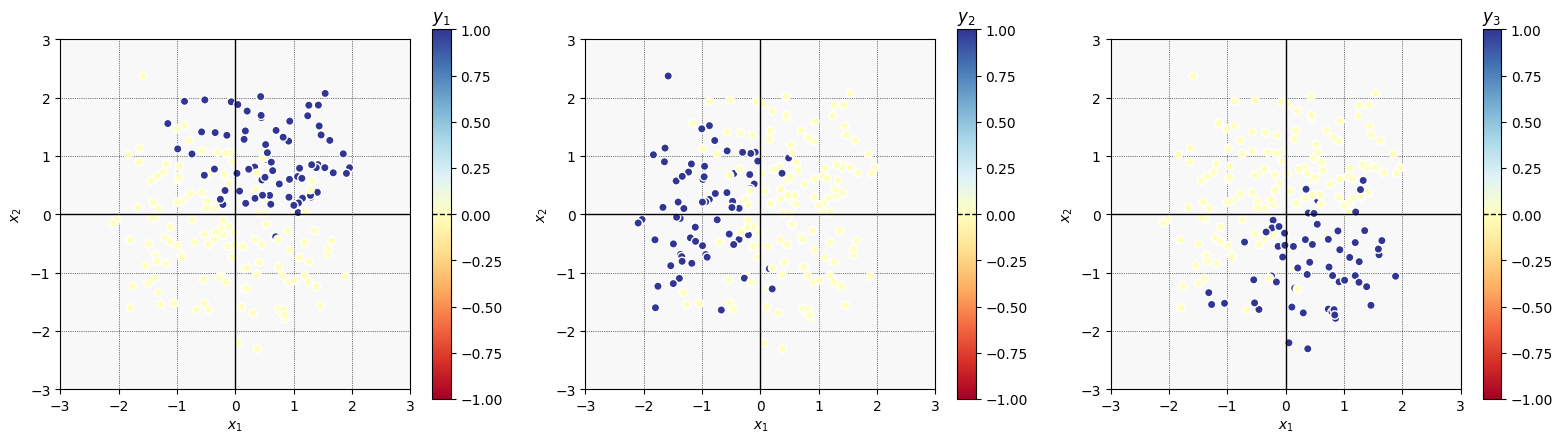

In [4]:
data.scatter(val_xs, val_ys)

Laten we eens proberen de trainingsdata te fitten met het neurale netwerk zoals we dat reeds hebben geprogrammeerd. We gebruiken een vergelijkbaar model als in het vorige hoofdstuk, alleen bevat dit nu twee hidden layers met respectievelijk een breedte van twintig en tien neuronen met een $\tanh$-activatiefunctie. Doordat dit multi-layer perceptron meer neuronen bevat dan we tot nu toe gewend zijn heeft het verhoudingsgewijs een grote capaciteit: tel maar uit dat het model *ruim 300* modelparameters bevat!

In [5]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_network

InputLayer(outputs=2, name='InputLayer_1') + DenseLayer(inputs=2, outputs=20, name='DenseLayer_1') + ActivationLayer(inputs=20, outputs=20, name='ActivationLayer_1') + DenseLayer(inputs=20, outputs=10, name='DenseLayer_2') + ActivationLayer(inputs=10, outputs=10, name='ActivationLayer_2') + DenseLayer(inputs=10, outputs=3, name='DenseLayer_3') + SoftmaxLayer(name='SoftmaxLayer_1') + LossLayer(inputs=3, outputs=0, name='LossLayer_1')

Het model is nog niet getraind, dus we kunnen nog geen zinvolle voorspellingen verwachten, maar laten we eens kijken hoe de trainingsdata op dit moment wordt behandeld. Vermoedelijk kent het model aan alle klassen willekeurige kansen toe in de buurt van $\frac{1}{3}$ (dat will zeggen, een grotendeels lichtblauwe achtergrond).

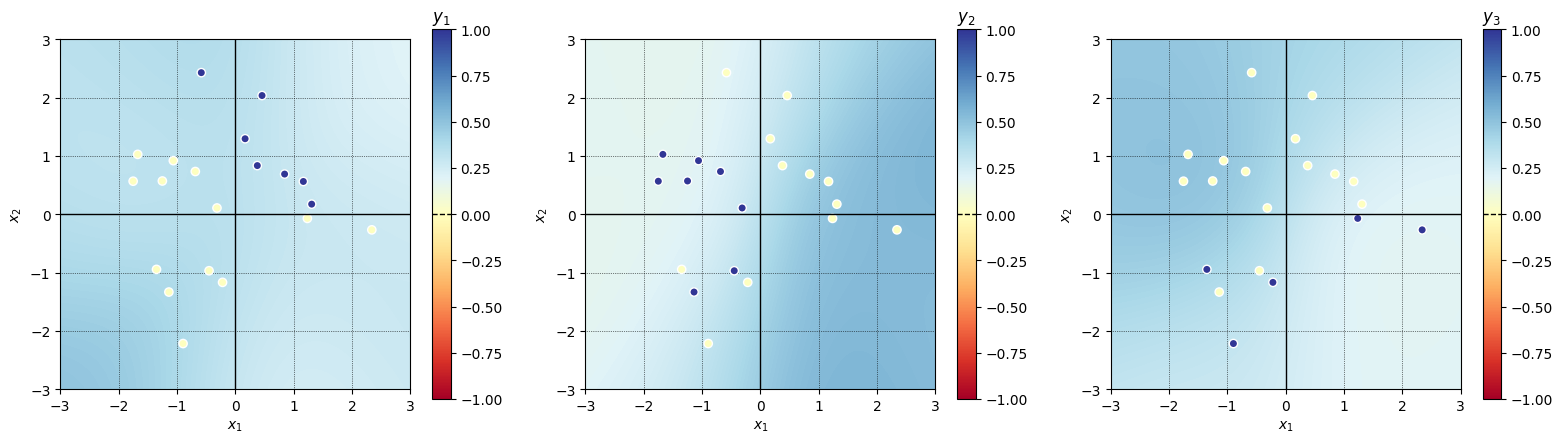

In [6]:
data.scatter(trn_xs, trn_ys, model=my_network)

Hieronder trainen we het model over vijftig epochs met een learning rate van 0.2. Deze waarden zijn als het goed is redelijk gekozen voor dit model en deze data, maar voel je vrij om deze hyperparameters te variëren om te zien wat het effect hiervan is.

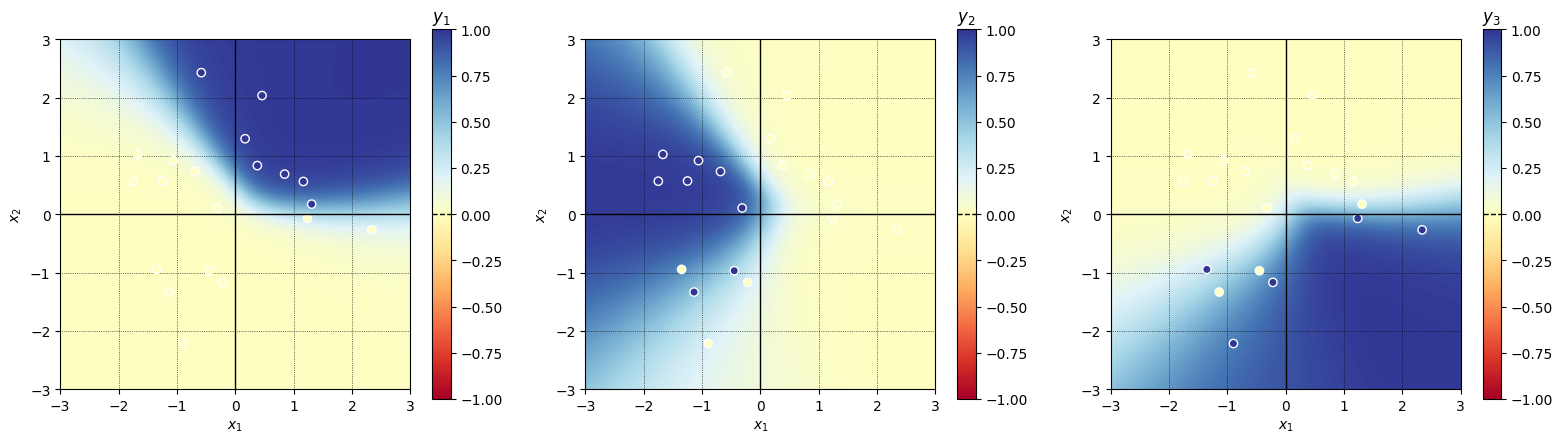

In [7]:
my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=50)
data.scatter(trn_xs, trn_ys, model=my_network)

Eigenlijk zou het model drie identieke taartpunten moeten opleveren die ten opzichte van elkaar rond de oorsprong gedraaid zijn. Door de toevalligheden in de data zal dit waarschijnlijk niet het geval zijn. Dit doet al enigszins vermoeden dat de data wel eens overfit zou kunnen zijn. Om dit beter te begrijpen gaan we de loss tijdens de training bijhouden.

Pas je `fit()` functie aan zodat deze een python lijst retourneert met daarin de waarde van de gemiddelde loss zoals die tijdens elke epoch werd bereikt. Omdat we later niet alleen een lijst met de trainingslosses maar ook eentje met de validatielosses willen teruggeven aan de gebruiker, stoppen we deze lijst als value in een dictionary genaamd `history` onder de key `'loss'`.

```python
    def fit(self, xs, ys, *, alpha=..., epochs=...):
		history = {'loss': []}
		for epoch in range(epochs):
			self.partial_fit(xs, ys, alpha=alpha)
            history['loss'].append(self.evaluate(xs, ys))
		return history
```

De bovenstaande code werkt weliswaar, maar is niet zo slim opgezet. Immers, je evalueert eerst het model voor alle instances in `xs` tijdens het trainen van een epoch met de `partial_fit()` methode, en daarna evalueer je nogmaals al diezelfde instances in `xs` om de loss te berekenen met de `evaluate()` methode. Het zou efficiënter zijn als de `partial_fit()` methode in één keer ook de gemiddelde loss van alle instances retourneert. Deze werd al berekend namelijk door de `__call__()` functie, alleen deden we daar tot dusverre niets mee. Dan zou je jezelf een aanroep van de `evaluate()` methode kunnen besparen, en dit vermindert de hoeveelheid rekenwerk substantieel.

Pas de bovenstaande voorbeeld-code voor de functie `fit()` en de bestaande code van de functie `partial_fit()` zelf zo veel als nodig aan zodat de `fit()` methode de `history` dictionary met de lijst met losses retourneert zónder dat de trainingsdata dubbel geëvalueerd hoeft te worden.

Hieronder zetten we nu opnieuw hetzelfde netwerk op als eerder hierboven, maar dit keer bewaren we de uitvoer van de `fit()`-aanroep in een variabele. We visualiseren wederom het gefitte model. Ziet de oplossing er ondanks een nieuwe willekeurige initialisatie op het oog hetzelfde uit als hierboven?

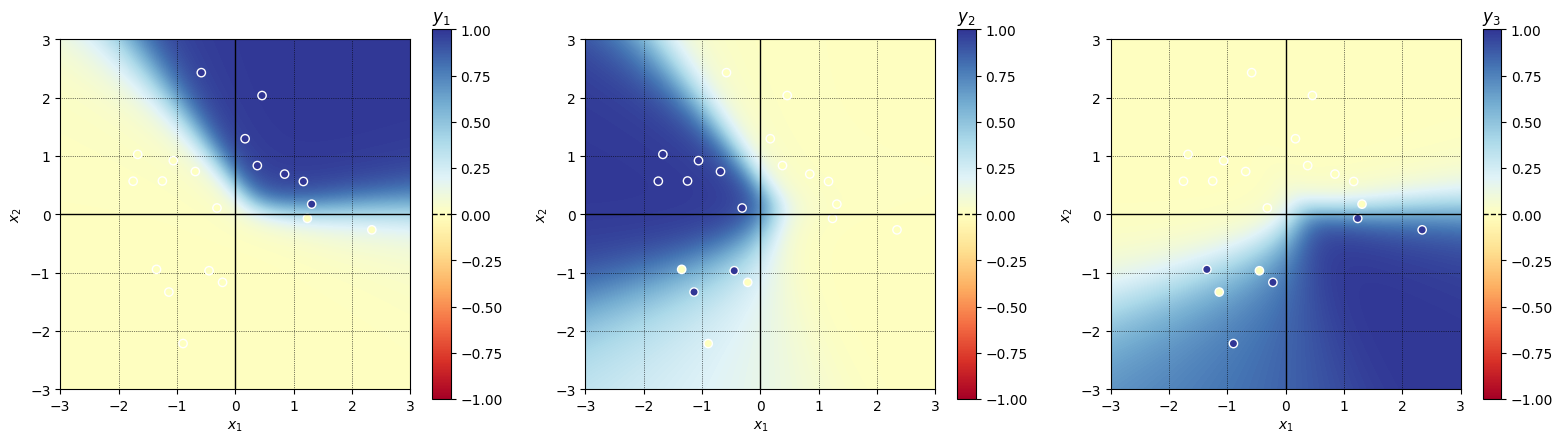

In [8]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=50)
data.scatter(trn_xs, trn_ys, model=my_network)

Controleer voor jezelf dat de `history` variabele na afloop inderdaad een dictionary bevat met één key `'loss'` met een bijbehorende value die een lijst van vijftig elementen bevat.

In [9]:
DataFrame(my_history['loss'], columns=['loss']).tail()

,loss
45,0.264304
46,0.262632
47,0.261025
48,0.259469
49,0.257959


Met de functie `data.curve()` kun je de waarden van de loss hieronder visualiseren. Je zou moeten zien dat de loss-curve als functie van de tijd steeds verder afneemt. Vanzelfsprekend komt dit omdat gradient descent de loss geleidelijk probeert te minimaliseren tijdens het trainen.

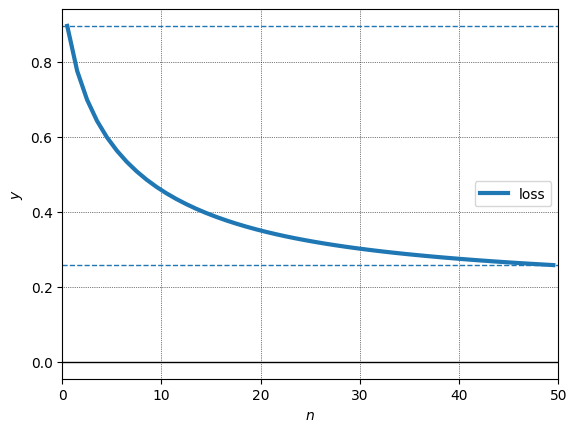

In [10]:
data.curve(my_history)

De trainingsdata geeft een nogal misleidend beeld van de kwaliteit van het model. Zeker omdat we hier een model hebben met een relatief grote capaciteit dat gefit wordt op een relatief kleine hoeveelheid trainingsdata lopen we het risico op overfitting. Ondanks dat we dat hier bewust zo gedaan hebben om de *bias-variance trade-off* te illustreren is dit natuurlijk eigenlijk onwenselijk. Daarom zouden we ook graag de loss behorende bij de validatiedata bij kunnen houden tijdens het trainen.

Voeg een extra optioneel argument `validation_data` toe aan je `fit()` methode. Zorg ervoor dat deze een tuple van twee (geneste) lijsten kan ontvangen met daarin de attributen en klasselabels van de validatiedata. Een aanroep met een syntax als

```python
fit(trn_xs, trn_ys, validation_data=(val_xs, val_ys))
```

zou daarmee mogelijk moeten worden. Als de gebruiker op deze manier validatiedata meegeeft dient de geretourneerde dictionary een extra key `'val_loss'` te bevatten met daarin een lijst met de gemiddelde validatieloss voor elke epoch. Richt je functie zo in dat het ook mogelijk blijft om géén validatiedata mee te geven met de bestaande syntax

```python
fit(trn_xs, trn_ys)
```

In dat geval dient de dictionary alleen de key `loss` te bevatten met daarin de gemiddelde trainingslosses.

Hieronder wordt wederom hetzelfde model als hierboven opgezet en getraind. Dit keer wordt ook de validatiedata meegegeven; hierop mag niet worden getraind, maar wel geëvalueerd. Als het goed is krijg je nu het kenmerkende gedrag te zien waarbij de validatieloss in de eerste epochs samen met de trainingsloss afneemt, maar dan geleidelijk begint af te buigen en na verloop van tijd zelfs weer toe gaat nemen. Dit is overduidelijk een indicatie dat er overfitting optreedt.

<div class="alert alert-info">

**Opmerking:**

De uitkomsten kunnen enigszins variëren omdat de data willekeurig wordt gegenereerd en het model willekeurig wordt geïnitialiseerd. Als je niet het verwachte gedrag ziet, controleer dan dat je de oorspronkelijke hyperparameters uit dit notebook gebruikt en train het model zonodig opnieuw.

</div>

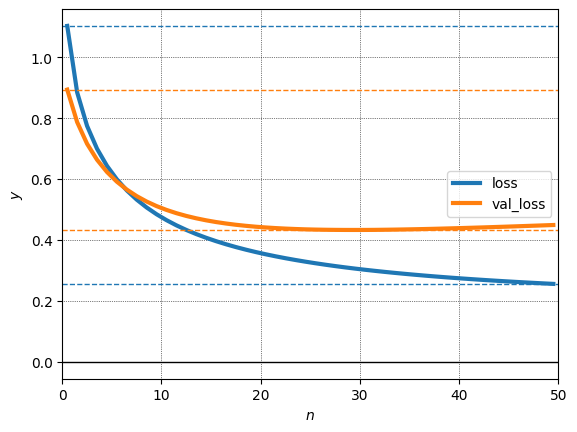

In [11]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=50, validation_data=(val_xs, val_ys))
data.curve(my_history)

### <a id='Batch_learning'>Batch learning</a>

Tot dusverre hebben we in de voorbeelden in deze werkcollege-hoofdstukken altijd gebruik gemaakt van *full batch learning* en *gradient descent*. Immers, de `__call__()` functies die de forward- en back-propagation uitvoeren krijgen een parameter `xs` mee met daarin de trainingsbatch, en hiervoor hebben we altijd de hele trainingsdataset gebruikt. Dit is prima voor kleine datasets, maar als er veel trainingsdata voorhanden zijn is het niet de meest efficiënte benadering.

We kunnen ons model verbeteren door het in staat te stellen om de trainingsdata in kleinere *mini-batches* te verdelen, en hiermee te trainen door middel van *stochastic gradient descent*. Je kan het model dan meerdere trainingsstappen laten zetten in één epoch. Dit leidt meestal tot snellere en betere convergentie. We zullen zowel de `partial_fit()` als de `fit()` methoden verder aanpassen om dit te bereiken.

- Voeg een extra argument `batch_size` toe aan de `partial_fit()` methode; kies dusdanige default waarden dat het model full batch learning uitvoert als er geen parameter wordt gespecificeerd. Laat de `partial_fit()` methode de dataset vervolgens in stukjes doorlopen van deze aangegeven grootte, en daarmee meerdere aanroepen van de `__call__()` methode uitvoeren. Zorg dat de gemiddelde loss (zoals je eerder in dit hoofdstuk hebt toegevoegd) evengoed correct over *alle* instances in de epoch wordt berekend en geretourneerd. Let tenslotte op dat je methode ook werkt als het totale aantal instances niet precies een veelvoud is van de `batch_size`; in dat geval zal de laatste mini-batch van een epoch een iets kleinere grootte hebben dan alle andere.

- Voeg functionaliteit toe aan de `fit()` methode zodat deze in elke epoch de trainingsinstances willekeurig door elkaar husselt voordat deze daarmee de `partial_fit()` methode aanroept. De functie `shuffle()` van de `random` module kan hierbij behulpzaam zijn. Let echter op dat de `xs` en `ys` op exact dezelfde wijze worden gepermuteerd omdat anders de uitkomsten in `ys` niet meer passen bij de bijbehorende attributen in `xs`; bedenk zelf een oplossing hoe je dit kan bereiken en test je idee uit voordat je dit in je module implementeert. Voeg tenslotte ook het nieuwe argument `batch_size` toe dat onveranderd kan worden doorgegeven aan de `partial_fit()` methode.

In de voorbeelddataset hierboven hadden we slechts twintig trainingsinstances. Laten we dat eens uitbreiden naar tweehonderd, evenveel als in de validatiedataset.

In [12]:
trn_xs, trn_ys = data.segments(3, num=200, noise=0.5)

Nu kunnen we het model trainen met mini-batches. Als we een batchgrootte van twintig kiezen - net zoveel als we voorheen in totaal in onze trainingsdata hadden zitten - worden in elke epoch $\frac{200}{20} = 10$ trainingsstappen uitgevoerd. Met twintig instances hebben we vermoedelijk elke keer wel een paar instances van elke klasse in onze mini-batch zitten, en de klassegrenzen zijn hier niet ingewikkeld van vorm, dus dat zou enigszins representatief moeten kunnen zijn voor de verdeling van alle mogelijke instances.

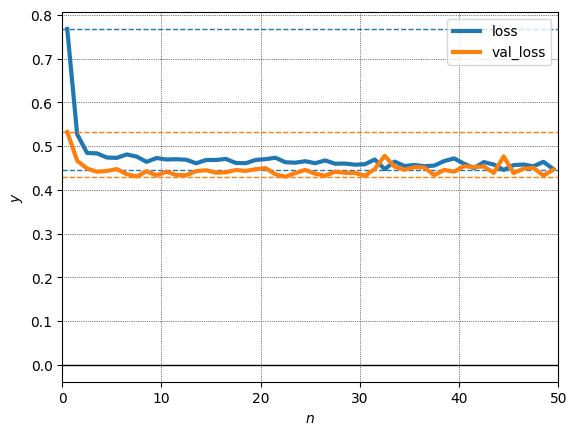

In [13]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=50, batch_size=20, validation_data=(val_xs, val_ys))
data.curve(my_history)

Vermoedelijk zie je enorme verschillen optreden in de bereikte validatiecurve, vergeleken met eerdere modellen waarin we full batch learning toepasten op een kleinere dataset. Let er daarbij op dat het bereik van de $y$-as anders kan zijn.

1. De curves gaan in het begin steiler omlaag, of misschien is niet eens te zien dat ze in de eerste epoch gedaald zijn. Dat komt omdat de modelparameters binnen één epoch al meerdere keren worden bijgewerkt en daardoor na afloop van de eerste epoch al flink gedaald zijn.

2. De curves zijn ruiziger. Dit komt omdat we nu op willekeurige mini-batches trainen die elk verschillende optimale modellen zouden opleveren waartussen we nu enigszins heen en weer springen.

3. De validatieloss neemt na verloop van tijd nauwelijks meer toe nu. Dit komt doordat de capaciteit van het model onvoldoende groot is om de toegenomen hoeveelheid trainingsdata te overfitten.

4. De validatieloss kan een lager optimum bereiken. Dit komt omdat er meer trainingsdata beschikbaar is waardoor er een beter model verkregen kan worden (denk terug aan het idee van de *leercurve*).

Op het tweede puntje na zijn dit allemaal voordelen.

Kijken we naar de validatiecurve, dan lijkt het erop dat al na een paar epochs reeds een optimaal model is bereikt dat noch underfit noch overfit. Hieronder trainen we een model daarom slechts vijf epochs lang.

In [14]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=5, batch_size=20, validation_data=(val_xs, val_ys))

Het eindresultaat hieronder ziet er een stuk representatiever uit dan het overfitte model van eerder hierboven. Om de prestaties betrouwbaar te evalueren testen we het model op een derde onafhankelijke dataset met *testdata*. Immers, de trainingsdata hebben we gebruikt om de modelparameters te trainen en de validatiedata hebben we gebruikt om het aantal epochs te bepalen, dus die zijn nu allebei "besmet".

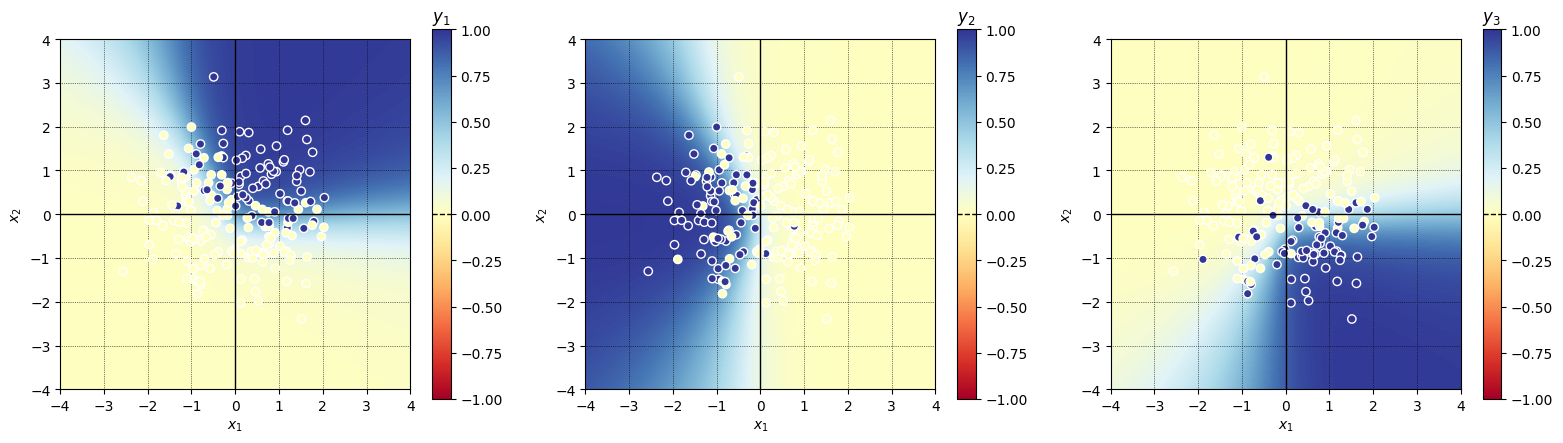

Loss: 0.50932956832052


In [15]:
tst_xs, tst_ys = data.segments(3, noise=0.5)
data.scatter(tst_xs, tst_ys, model=my_network)
print(f'Loss: {my_network.evaluate(tst_xs, tst_ys)}')

<div class="alert alert-success">

**Gefeliciteerd!**

Een beter presterend machine learning model met een lagere gemiddelde loss dan dit is gezien de aanwezigheid van willekeurige ruis in de data eigenlijk niet te maken.

</div>


### <a id='Early_stopping'>Early stopping</a>

Om tot slot early stopping toe te passen stappen we over op een iets complexere dataset die zal worden getrokken uit een zogenaamde [Newton fractal](https://en.wikipedia.org/wiki/Newton_fractal). De details doen er nu niet zoveel toe, maar een kenmerk van fractals is dat ze op elke grootte-schaal details bevatten. Een eindige dataset kan die details nooit allemaal representeren, en een neuraal netwerk kan evenmin al die kenmerken fitten, maar het is interessant om te kijken hoe ver een model kan komen.

Grafisch ziet de fractal die wij zullen gebruiken er als volgt uit. De horizontale en vertikale richting komen overeen met twee attributen $x_1$ en $x_2$ en elke kleur correspondeert met een klasse (blauw, rood, en groen). Opmerkelijk is dat op elke grens tussen twee klassen altijd eilandjes liggen van de derde klasse. Maar op de grenzen met die eilandjes liggen ook weer kleinere eilandjes, *ad infinitum*. Je kan er over filosoferen of de klassen überhaupt wel ergens paarsgewijs aan elkaar grenzen (het antwoord is nee: de hele grens bestaat uit "drielandenpunten"; een bizar idee).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Julia_set_for_the_rational_function.png/1200px-Julia_set_for_the_rational_function.png" width=480 height=360/>

Hoe dan ook, gegeven is een functie `data.fractal()` die een steekproef neemt van een bepaald aantal punten uit deze dataset. Er bestaan ook versies met meer dan drie klassen; een verplicht argument geeft daarom aan hoeveel klassen we willen kiezen. We genereren duizend trainingsinstances, tweehonderd validatieinstances, en tweehonderd testinstances.

In [16]:
trn_xs, trn_ys = data.fractal(3, num=1000)
val_xs, val_ys = data.fractal(3, num=200)
tst_xs, tst_ys = data.fractal(3, num=200)

Laten we eerst weer kijken hoe de data er uitziet. De klassen die je ziet komen van links naar rechts overeen met de blauwe, rode, en groene klassen uit de afbeelding hierboven.

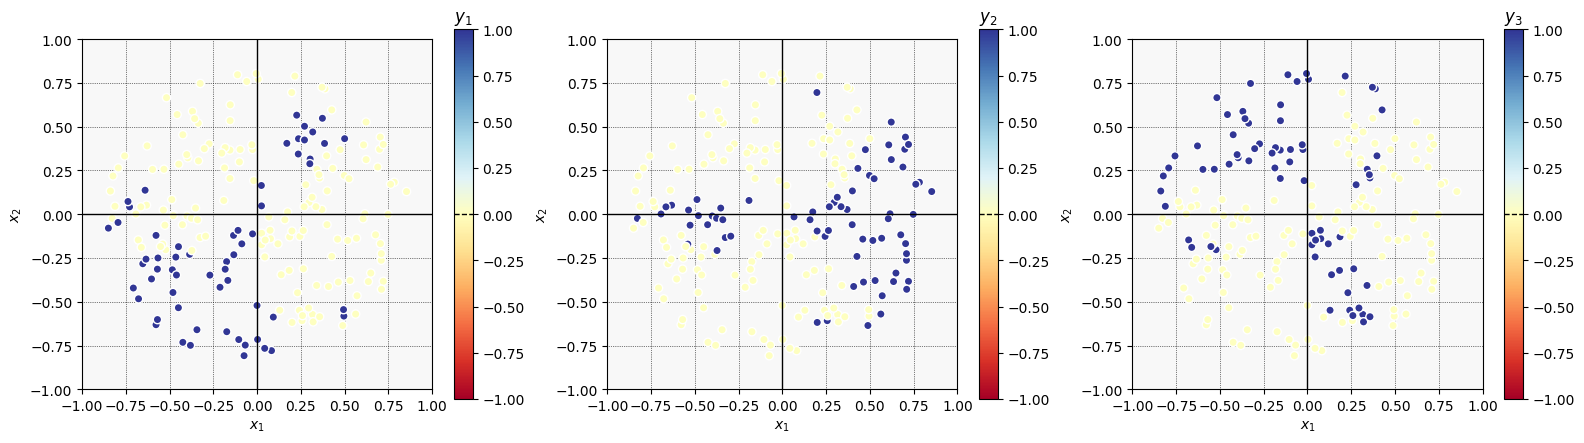

In [17]:
data.scatter(val_xs, val_ys)

Laten we weer eens precies hetzelfde model toepassen dat we eerder hebben bekeken. Eerst nog weer eens met full batch learning, dit keer met slechts tien epochs om de rekentijd te beperken. De learning rate stellen we in op $\alpha = 5$.

In [18]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=5.0, epochs=10, validation_data=(val_xs, val_ys))

Visualiseren we de uitkomsten dan zie je vermoedelijk totaal onzinnige resultaten.

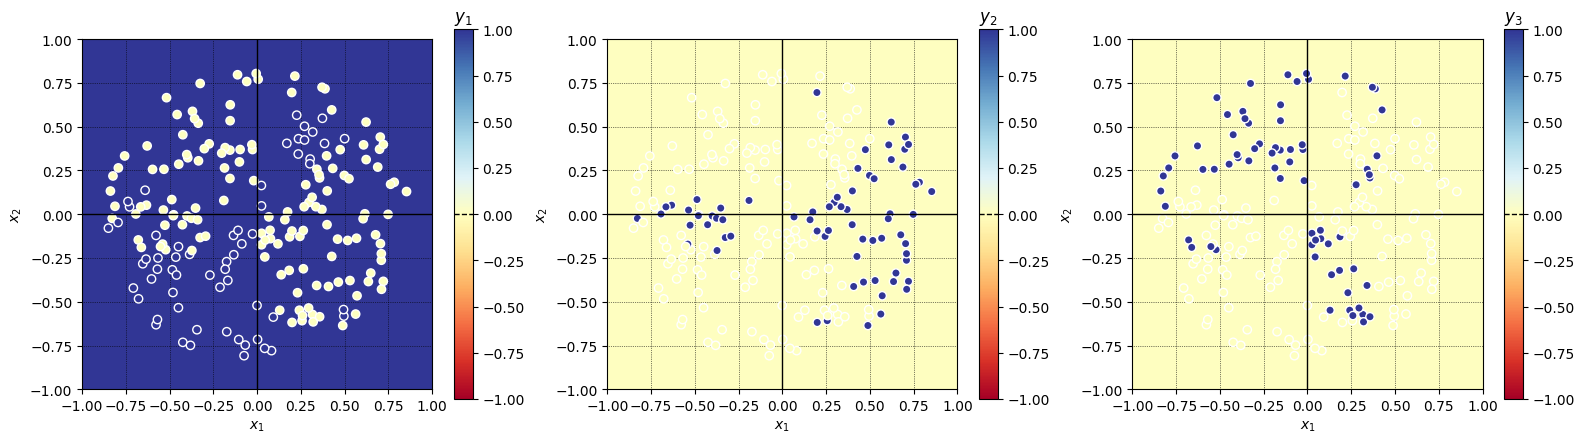

In [19]:
data.scatter(val_xs, val_ys, model=my_network)

Als we kijken naar de validatiecurve zien we dat zowel de trainingsloss als de validatieloss niet zijn afgenomen, maar eerder zijn toegenomen, of wilde sprongen laten zien. Dit duidt erop dat gradient descent niet gewerkt heeft: we convergeren niet naar een oplossing. Dit heeft er in dit geval mee te maken dat we een te grote learning rate hebben gekozen.

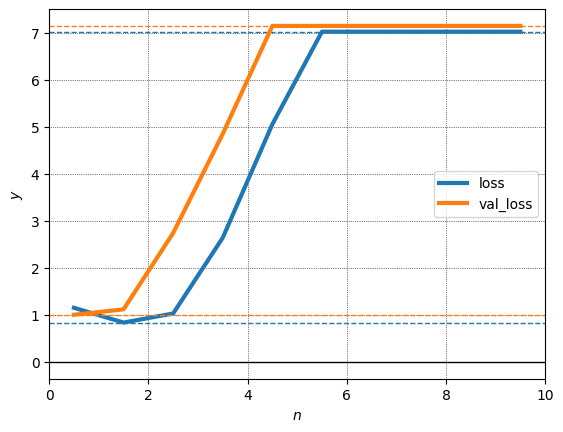

In [20]:
data.curve(my_history)

In zo'n geval kan de learning rate worden verlaagd. Omdat we dan langzamer leren zullen we vermoedelijk het aantal epochs ook moeten verhogen. Als gevolg hiervan zal het trainen van het model langer duren.

Hieronder hebben we `alpha` vijf keer zo klein gekozen en het aantal epochs evenredig vergroot. Ook werken we in kleinere mini-batches van honderd instances per keer: weliswaar hebben we nog steeds maar drie klassen, maar die hebben wel een ingewikkeldere verdeling, dus we gebruiken meer instances per mini-batch in een poging om telkens een representatieve steekproef te krijgen. Vermoedelijk zie je nu dat de losses niet meer toenemen en mogelijk beginnen te dalen.

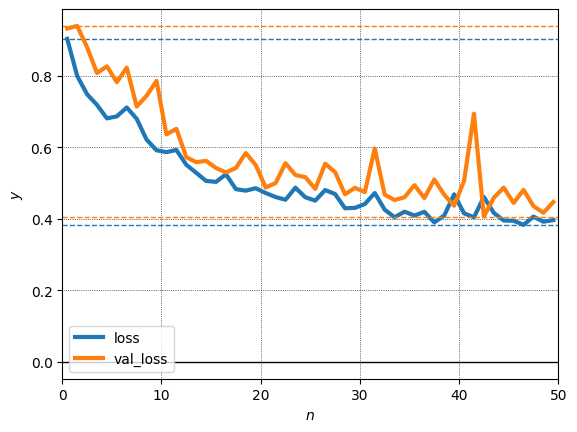

In [21]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=1.0, epochs=50, batch_size=100, validation_data=(val_xs, val_ys))
data.curve(my_history)

Nog steeds neemt de validatiecurve waarschijnlijk niet overal geleidelijk af, en kunnen er heftige oscillaties inzitten. Dit duidt er op dat gradient descent her en der nog steeds over de oplossing heen (en weer) neigt te springen. We kunnen proberen de learning rate nogmaals een factor vijf te verlagen. Het aantal benodigde epochs neemt daarmee helaas verder toe, waardoor het langzamerhand erg lang begint te duren om een model te trainen. Wel bereiken we een steeds kleinere validatieloss.

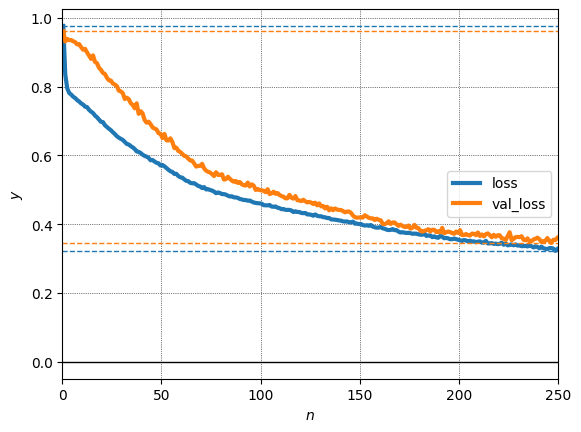

In [22]:
my_network = model.InputLayer(2) + \
             model.DenseLayer(20) + model.ActivationLayer(20, activation=model.tanh) + \
             model.DenseLayer(10) + model.ActivationLayer(10, activation=model.tanh) + \
             model.DenseLayer(3) + model.SoftmaxLayer(3) + \
             model.LossLayer(loss=model.categorical_crossentropy)
my_history = my_network.fit(trn_xs, trn_ys, alpha=0.2, epochs=250, batch_size=100, validation_data=(val_xs, val_ys))
data.curve(my_history)

De problemen lijken nu grotendeels opgelost te zijn. Als we de afvlakkende validatiecurve zo bekijken naderen we gelukkig het optimale aantal epochs enigszins. Dus nu is het tijd om nogmaals te bekijken hoe het model het doet op de testdata.

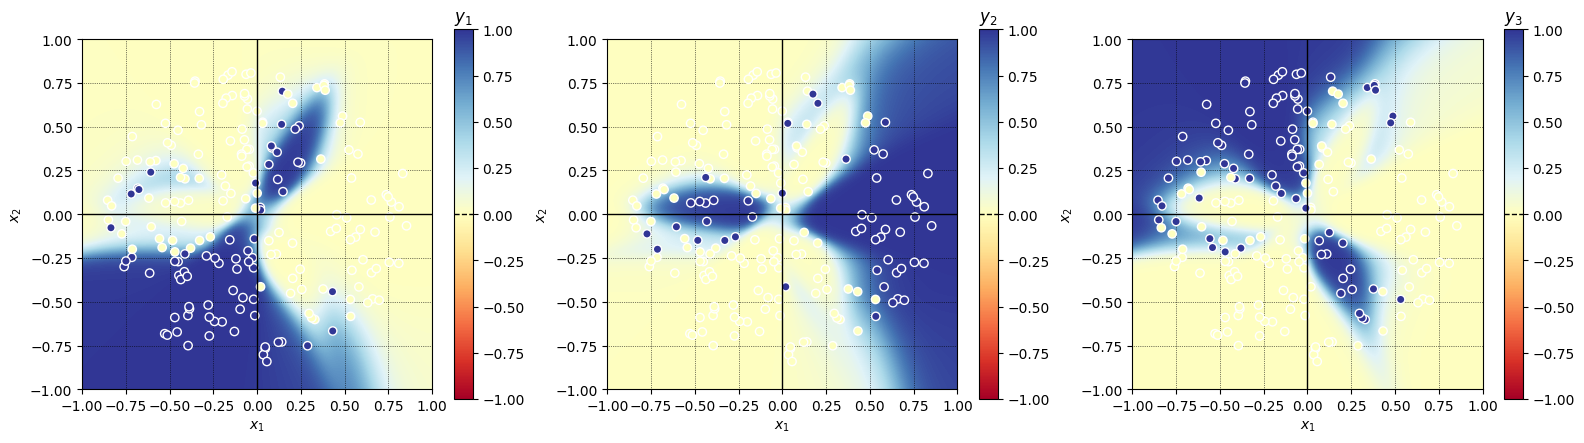

Loss: 0.37209544554121776


In [23]:
data.scatter(tst_xs, tst_ys, model=my_network)
print(f'Loss: {my_network.evaluate(tst_xs, tst_ys)}')

Je ziet nu als het goed is dat je model al behoorlijk wat karakteristieke details heeft weten te leren over de verdeling van de data. Natuurlijk is het resultaat nog lang niet perfect, deels omdat de hoeveelheid trainingsdata nog steeds beperkt was en deels omdat het model voor deze data een te lage capaciteit heeft. Je zou dus winst kunnen boeken door meer neuronen toe te voegen en je model herhaaldelijk te trainen met afnemende $\alpha$ en een toenemend aantal epochs. Maar hopelijk zie je dat je al een aardig voorspellend model hebt kunnen maken voor een complexe dataset. Het enige dat nodig is om nog betere resultaten te verkijgen is méér trainingsdata, méér neuronen, méér rekentijd, en méér geduld.

Iets soortgelijks kan natuurlijk ook met standaard libraries bereikt worden. We hebben de opzet en syntax van onze module steeds vergelijkbaar gehouden met `tensorflow.keras`. Ook het visualiseren van een validatiecurve en het werken met mini-batches gaat op een nagenoeg identieke manier.

We zetten eerst alle data om in `numpy` arrays.

In [24]:
krs_trn_xs, krs_trn_ys = array(trn_xs), array(trn_ys)
krs_val_xs, krs_val_ys = array(val_xs), array(val_ys)
krs_tst_xs, krs_tst_ys = array(tst_xs), array(tst_ys)

Nemen we eenzelfde model als hierboven dan krijgen we het volgende resultaat.

In [25]:
krs_network = keras.models.Sequential()
krs_network.add(keras.layers.InputLayer(input_shape=(2, )))
krs_network.add(keras.layers.Dense(20))
krs_network.add(keras.layers.Activation(activation=keras.activations.tanh))
krs_network.add(keras.layers.Dense(10))
krs_network.add(keras.layers.Activation(activation=keras.activations.tanh))
krs_network.add(keras.layers.Dense(3))
krs_network.add(keras.layers.Activation(activation=keras.activations.softmax))
krs_network.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.SGD(learning_rate=0.2))
krs_history = krs_network.fit(krs_trn_xs, krs_trn_ys, epochs=250, batch_size=100, validation_data=(krs_val_xs, krs_val_ys), verbose=0)

2023-04-19 12:15:53.223883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-19 12:15:53.224098: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-19 12:15:53.224116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (orfeasLaptop): /proc/driver/nvidia/version does not exist
2023-04-19 12:15:53.224477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Je merkt nu waarschijnlijk goed dat keras op dit soort grotere en ingewikkeldere datasets veel sneller traint dan wij met ons model kunnen. De snelheid van ons eigen model is prima te optimaliseren door gebruik te maken van datatypen uit modules die de berekeningen efficiënter kunnen uitvoeren (zoals `numpy` en `numba`), maar dit voert te ver voor nu. Het eindresultaat is echter uitermate vergelijkbaar!

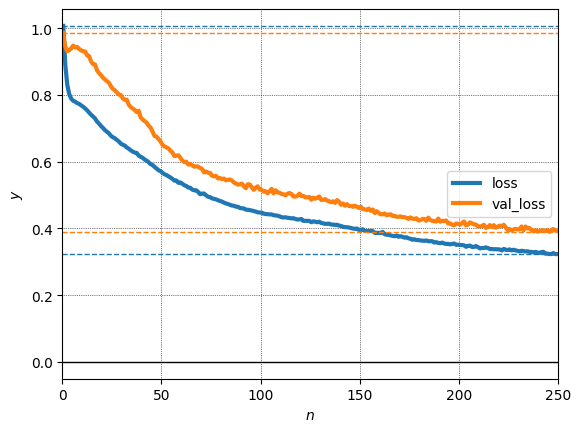

In [26]:
data.curve(krs_history.history)

Het uiteindelijke model ziet er kwalitatief ook soortgelijk uit als dat van ons, en de behaalde gemiddelde loss van keras wijkt niet substantieel af van die van ons.

521/521 [==============================] - 0s 716us/step


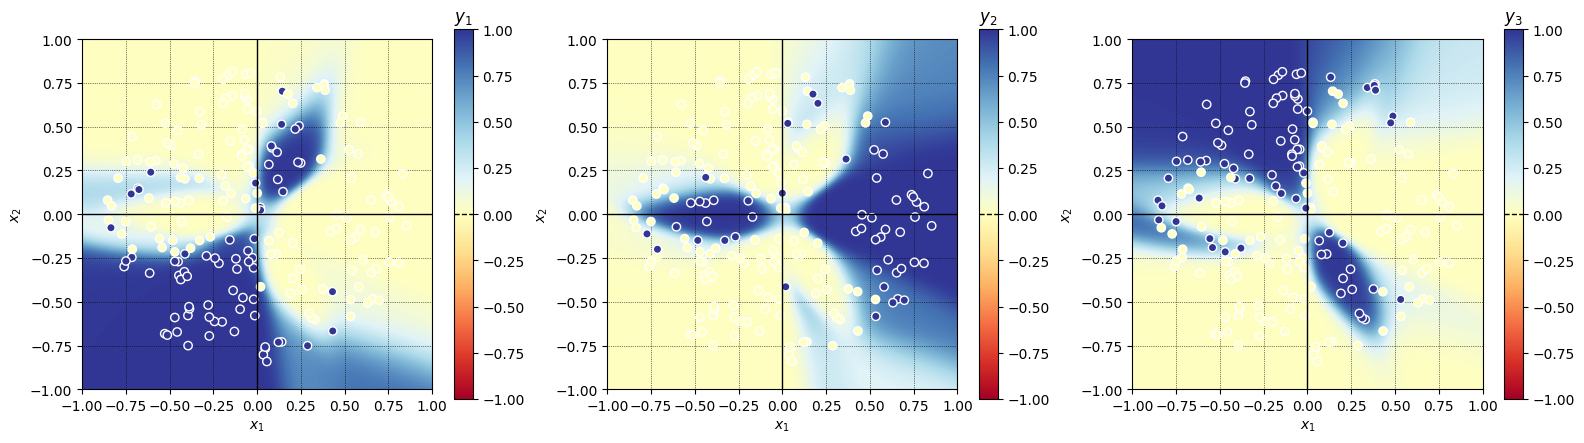

Loss: 0.3457835912704468


In [27]:
data.scatter(krs_tst_xs, krs_tst_ys, model=krs_network)
print(f'Loss: {krs_network.evaluate(krs_tst_xs, krs_tst_ys, verbose=0)}')

<div class="alert alert-success">

**Gefeliciteerd!**

Hiep hiep hoera; je model is af. Geef jezelf een schouderklop, want dit alles was - om het eufemistisch uit te drukken - lang geen peuleschil.

</div>

***

<small>&copy; 2023, Dave R.M. Langers, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl)</small>